# Analysis (Chapter 1)

### Overview

All datasets can be obtained by running the code below. The data will be sorted in the `./analysis_data/` folder. The format is the same as that of data you used in the previous part of this assignment, so make sure you change the dataset paths in the *assignment3.ipynb* to the correct data folder, except for the `common_words` stopwords. Also, set the RESET flag to `True`. Finally, make sure you dig around the dataset you are working with, to get familiar with the type of queries and documents, the type of relevance judgements, etc.

### Install

In [1]:
!pip install --upgrade ir_datasets
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### Import

In [2]:
import ir_datasets
import csv
import os
from tqdm import tqdm
import random

### Function to save data in the .tsv format

In [3]:
def save_tsv(
    folder_name,
    dataset_path,
    concatenate_docs=False,
    doc_text=None,
    extract_partial=False,
    extract=None,
    provide_n_docs=False,
    n_docs=None,
    **kwargs,
):
    """
    Saves queries, documents and qrels in asisgnment-specific .tsv format.

    Input:
        - dataset_path: dataset to be downloaded using ir_dataset package
        - folder_name: name of the folder within the data_for_analysis folder
    """
    # Check if the folder exists, and if not, create it
    folder_path = "analysis_data/" + folder_name
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        dataset = ir_datasets.load(dataset_path)

    # Queries
    print(f"Extracting queries of {folder_name} ...")
    query_path = os.path.join(folder_path, "queries.tsv")
    if not os.path.exists(query_path):
        total_queries = sum(1 for _ in dataset.queries_iter())
        with open(query_path, "w", newline="", encoding="utf-8") as tsv_file:
            tsv_writer = csv.writer(tsv_file, delimiter="\t")
            for query in tqdm(
                dataset.queries_iter(), total=total_queries, desc="Saving queries"
            ):
                tsv_writer.writerow([query[0], query[1]])

    # Docs
    print(f"Extracting documents of {folder_name} ...")
    doc_path = os.path.join(folder_path, "collection.tsv")
    if not os.path.exists(doc_path):

        total_docs = n_docs if provide_n_docs else sum(1 for _ in dataset.docs_iter())
        sampled_docs = (
            random.sample(list(dataset.docs_iter()), extract)
            if extract_partial
            else dataset.docs_iter()
        )

        with open(doc_path, "w", newline="", encoding="utf-8") as tsv_file:
            tsv_writer = csv.writer(tsv_file, delimiter="\t")
            for doc in tqdm(dataset.docs_iter(), total=total_docs, desc="Saving docs"):
                if concatenate_docs:
                    tsv_writer.writerow(
                        [doc[0], f"{doc[doc_text[0]]} {doc[doc_text[1]]}"]
                    )
                else:
                    tsv_writer.writerow([doc[0], doc[1]])

    # Qrels
    print(f"Extracting qrels of {folder_name} ...")
    ## Initialize file handles only if they don't exist
    train_file_path = os.path.join(folder_path, "train_pairs_graded.tsv")
    dev_file_path = os.path.join(folder_path, "dev_pairs_graded.tsv")
    test_file_path = os.path.join(folder_path, "test_pairs_graded.tsv")

    if not os.path.exists(train_file_path):
        total_qrels = sum(1 for _ in dataset.qrels_iter())

        ## Calculate the indices to split the data
        index_80_percent = int(0.8 * total_qrels)
        index_90_percent = int(0.9 * total_qrels)

        with open(
            os.path.join(folder_path, "train_pairs_graded.tsv"),
            "w",
            newline="",
            encoding="utf-8",
        ) as train_file, open(
            os.path.join(folder_path, "dev_pairs_graded.tsv"),
            "w",
            newline="",
            encoding="utf-8",
        ) as dev_file, open(
            os.path.join(folder_path, "test_pairs_graded.tsv"),
            "w",
            newline="",
            encoding="utf-8",
        ) as test_file:

            train_writer = csv.writer(train_file, delimiter="\t")
            dev_writer = csv.writer(dev_file, delimiter="\t")
            test_writer = csv.writer(test_file, delimiter="\t")

            for i, qrel in tqdm(
                enumerate(dataset.qrels_iter()), total=total_qrels, desc="Saving qrels"
            ):
                if i < index_80_percent:
                    train_writer.writerow([qrel[0], qrel[1], qrel[2]])
                elif i < index_90_percent:
                    dev_writer.writerow([qrel[0], qrel[1], qrel[2]])
                else:
                    test_writer.writerow([qrel[0], qrel[1], qrel[2]])

In [4]:
datasets_to_save = {
    "GENOMICS": {
        "dataset_path": "medline/2004/trec-genomics-2005",
        "concatenate_docs": True,
        "doc_text": [1, 2],
    },
    "ARGS": {
        "dataset_path": "argsme/2020-04-01/touche-2021-task-1",
        "concatenate_docs": True,
        "doc_text": [3, 1],
    },
    "GAMING": {
        "dataset_path": "beir/cqadupstack/gaming",
        "concatenate_docs": True,
        "doc_text": [2, 1],
    },
    "NUTRITION": {
        "dataset_path": "nfcorpus/train/nontopic",
        "concatenate_docs": True,
        "doc_text": [2, 3],
    },
    "CLIMATE": {
        "dataset_path": "beir/climate-fever",
        "concatenate_docs": True,
        "doc_text": [2, 1],
    },
    "BUSINESS": {
        "dataset_path": "beir/fiqa/train",
    },
}

### Did you choose your scenario? Let's get the dataset! 
Please use the Dataset name as specified in the markdown cells above.

In [5]:
scenario = "NUTRITION" #input("What scenario are you interested in? ")
while scenario not in datasets_to_save.keys():
    print("Please specify a valid scenario.")
    scenario = input("What scenario are you interested in? ")

print(f"Saving {scenario} ...")
save_tsv(scenario, **datasets_to_save[scenario])

Saving NUTRITION ...
Extracting queries of NUTRITION ...
Extracting documents of NUTRITION ...
Extracting qrels of NUTRITION ...


## Comparing Pointwise, Pairwise and Listwise

In the next few cells, we will compare the methods you've implemented. Helper functions are provided for you, which you can use to make some conclusions. You can modify the code as needed!

First, let's have a function that plots the average scores of relevant (levels 3 and 4) and non-relevant (levels 0, 1, and 2) scores in terms of training epochs for different loss functions:

In [6]:
# Load metrics and models
import json
import torch
from ltr.model import LTRModel

N_FEATURES = 15

pointwise_temp_model = LTRModel(N_FEATURES)
pointwise_temp_model.load_state_dict(torch.load("./outputs/pointwise_model"))

pairwise_temp_model = LTRModel(N_FEATURES)
pairwise_temp_model.load_state_dict(torch.load("./outputs/pairwise_spedup_model"))

listwise_temp_model = LTRModel(N_FEATURES)
listwise_temp_model.load_state_dict(torch.load("./outputs/listwise_model"))


methods = [
    {"results_file": "./outputs/pointwise_res.json", "label": "Pointwise"},
    {"results_file": "./outputs/pairwise_spedup_res.json", "label": "Pairwise"},
    {"results_file": "./outputs/listwise_res.json", "label": "Listwise"},
]

labels = []
results = []
q_results = []
for m in methods:
    labels.append(m["label"])

    with open(m["results_file"]) as reader:
        r = json.load(reader)

    results.append(r["test_metrics"])
    q_results.append(r["test_query_level_metrics"])

In the following cell, `compare_methods` and `plot_distribution` figures are imported. You can use the them for your analysis and observe how the different loss functions compare to each other.

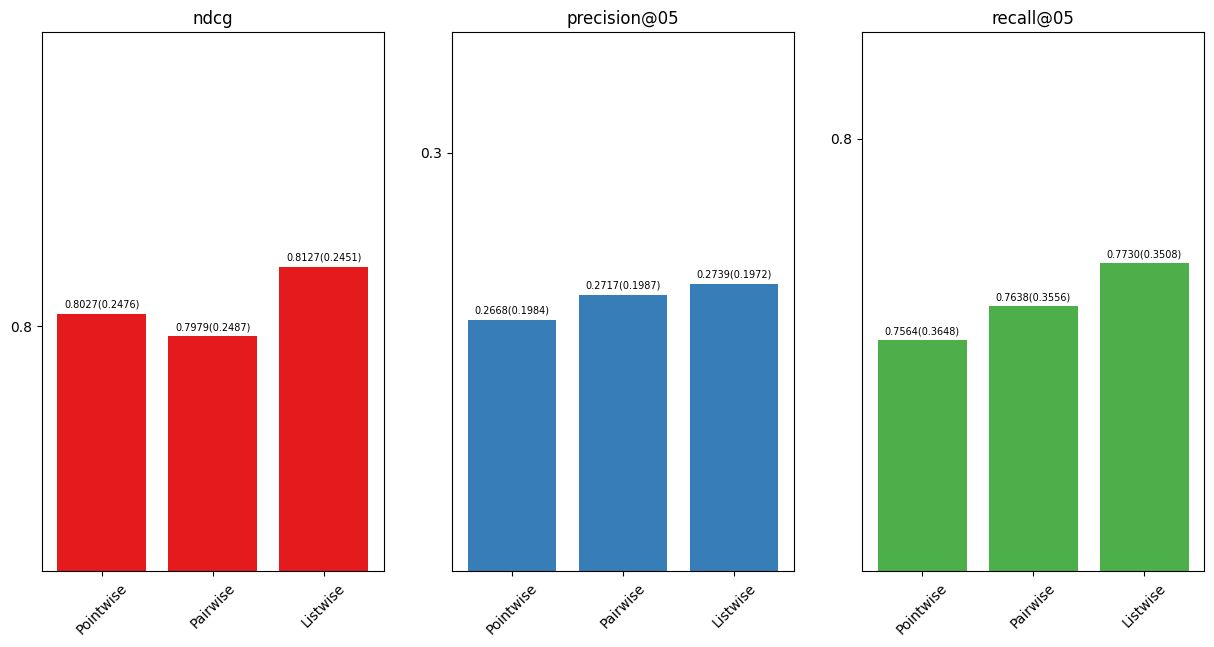

In [7]:
from ltr.utils import compare_methods

compare_methods(labels, results)

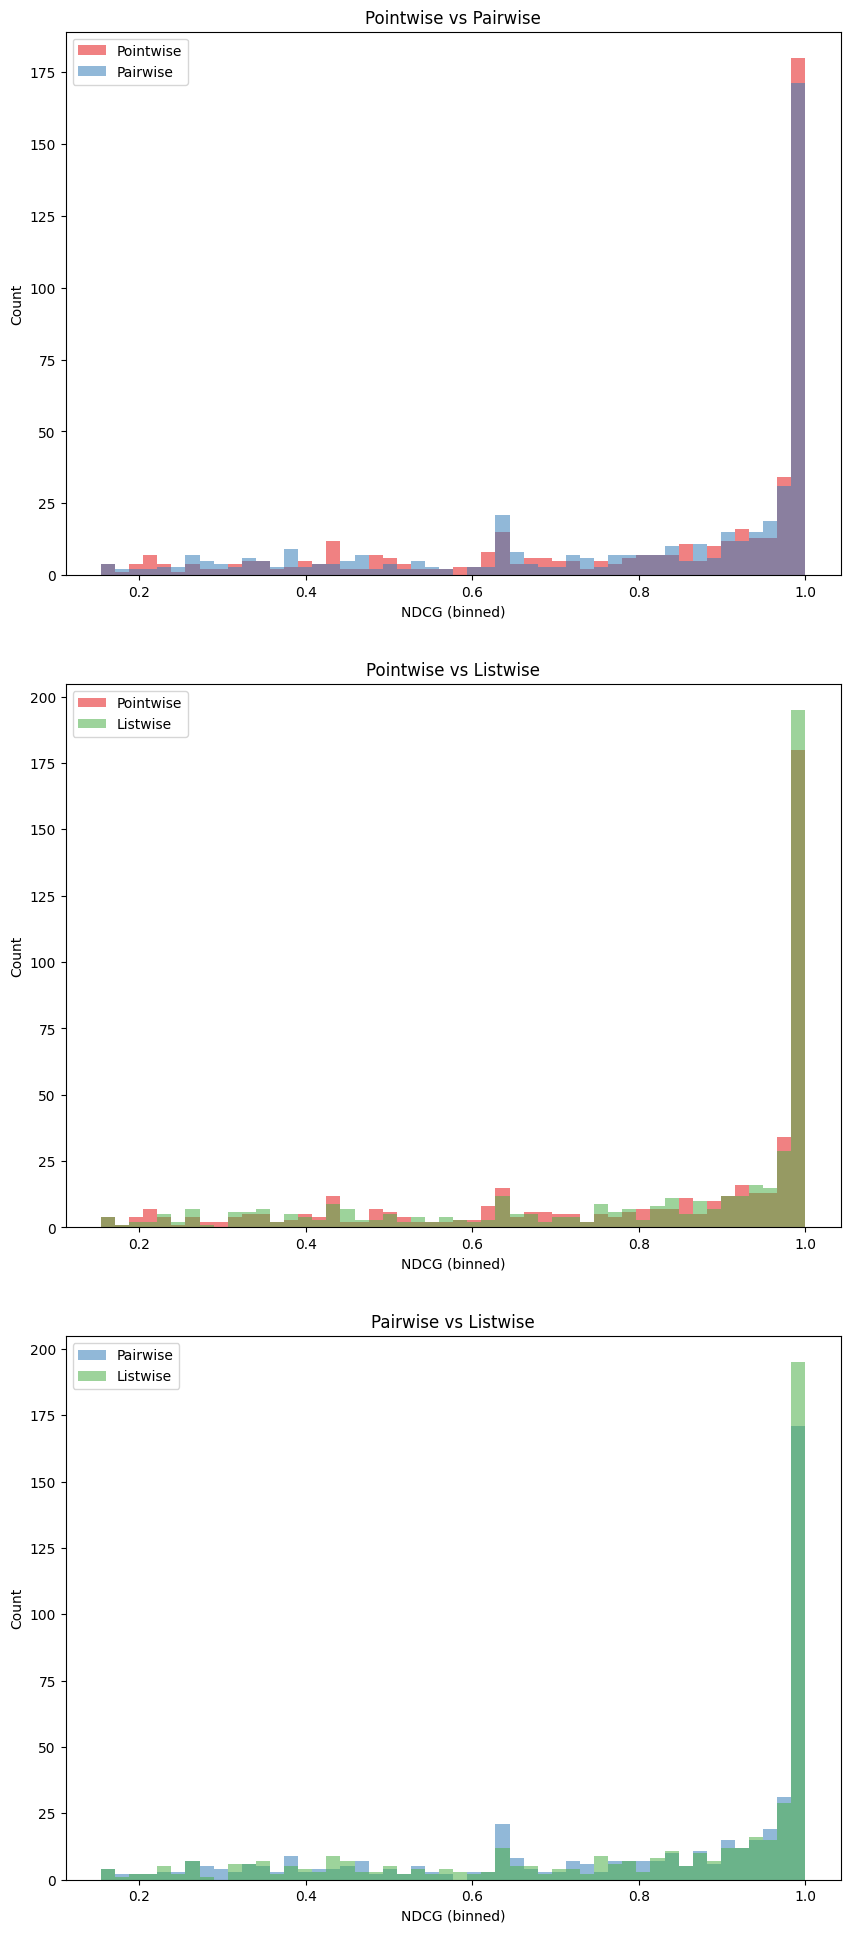

In [8]:
from ltr.utils import plot_distribution

plot_distribution(labels, q_results)

1. Given the training results and evaluation results, please elaborate on the ranking performance with different loss functions.

2. In this assignment, you extracted N_FEATURES features for each query-document pair. Now, consider adding 1-2 new features, and run the training again. Analyze training performance with the extended feature vectors.

See the Canvas assignment for further details and to submit your results.

## Comparing Pointwise, Pairwise and Listwise NUTRITION

In the next few cells, we will compare the methods you've implemented. Helper functions are provided for you, which you can use to make some conclusions. You can modify the code as needed!

First, let's have a function that plots the average scores of relevant (levels 3 and 4) and non-relevant (levels 0, 1, and 2) scores in terms of training epochs for different loss functions:

In [9]:
# Load metrics and models
import json
import torch
from ltr.model import LTRModel

N_FEATURES = 15

pointwise_temp_model = LTRModel(N_FEATURES)
pointwise_temp_model.load_state_dict(torch.load("./analysis_data/outputs_nutrition/pointwise_model"))

pairwise_temp_model = LTRModel(N_FEATURES)
pairwise_temp_model.load_state_dict(torch.load("./analysis_data/outputs_nutrition/pairwise_spedup_model"))

listwise_temp_model = LTRModel(N_FEATURES)
listwise_temp_model.load_state_dict(torch.load("./analysis_data/outputs_nutrition/listwise_model"))


methods = [
    {"results_file": "./analysis_data/outputs_nutrition/pointwise_res.json", "label": "Pointwise"},
    {"results_file": "./analysis_data/outputs_nutrition/pairwise_spedup_res.json", "label": "Pairwise"},
    {"results_file": "./analysis_data/outputs_nutrition/listwise_res.json", "label": "Listwise"},
]

labels = []
results = []
q_results = []
for m in methods:
    labels.append(m["label"])

    with open(m["results_file"]) as reader:
        r = json.load(reader)

    results.append(r["test_metrics"])
    q_results.append(r["test_query_level_metrics"])

In the following cell, `compare_methods` and `plot_distribution` figures are imported. You can use the them for your analysis and observe how the different loss functions compare to each other.

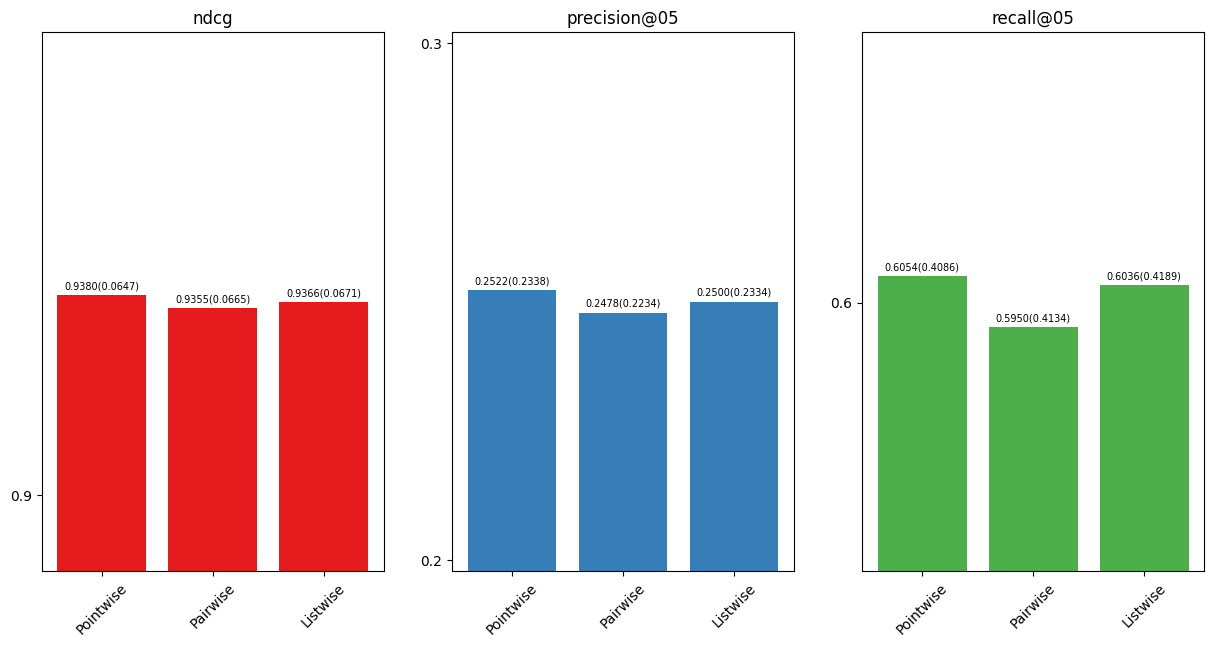

In [10]:
from ltr.utils import compare_methods

compare_methods(labels, results)

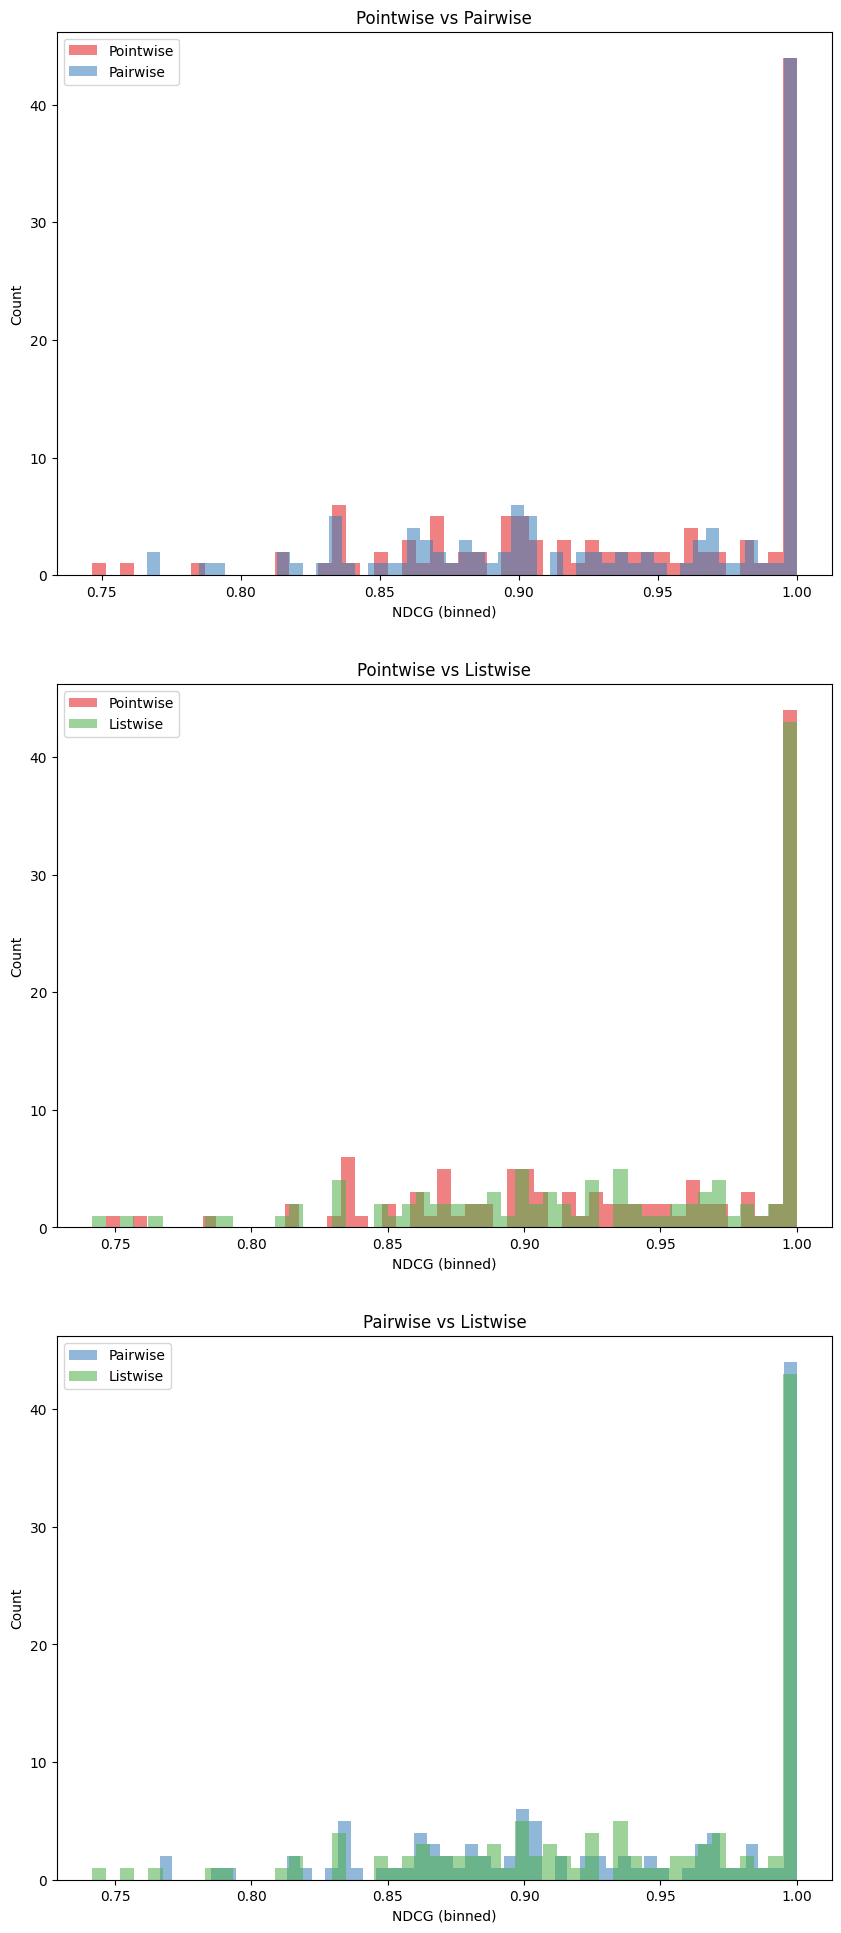

In [11]:
from ltr.utils import plot_distribution

plot_distribution(labels, q_results)

## Comparing Pointwise, Pairwise and Listwise NUTRITION NEW

In the next few cells, we will compare the methods you've implemented. Helper functions are provided for you, which you can use to make some conclusions. You can modify the code as needed!

First, let's have a function that plots the average scores of relevant (levels 3 and 4) and non-relevant (levels 0, 1, and 2) scores in terms of training epochs for different loss functions:

In [1]:
# Load metrics and models
import json
import torch
from ltr.model import LTRModel

N_FEATURES = 17

pointwise_temp_model = LTRModel(N_FEATURES)
pointwise_temp_model.load_state_dict(torch.load("./analysis_data/outputs_nutrition_new/pointwise_model"))

pairwise_temp_model = LTRModel(N_FEATURES)
pairwise_temp_model.load_state_dict(torch.load("./analysis_data/outputs_nutrition_new/pairwise_spedup_model"))

listwise_temp_model = LTRModel(N_FEATURES)
listwise_temp_model.load_state_dict(torch.load("./analysis_data/outputs_nutrition_new/listwise_model"))


methods = [
    {"results_file": "./analysis_data/outputs_nutrition_new/pointwise_res.json", "label": "Pointwise"},
    {"results_file": "./analysis_data/outputs_nutrition_new/pairwise_spedup_res.json", "label": "Pairwise"},
    {"results_file": "./analysis_data/outputs_nutrition_new/listwise_res.json", "label": "Listwise"},
]

labels = []
results = []
q_results = []
for m in methods:
    labels.append(m["label"])

    with open(m["results_file"]) as reader:
        r = json.load(reader)

    results.append(r["test_metrics"])
    q_results.append(r["test_query_level_metrics"])

In the following cell, `compare_methods` and `plot_distribution` figures are imported. You can use the them for your analysis and observe how the different loss functions compare to each other.

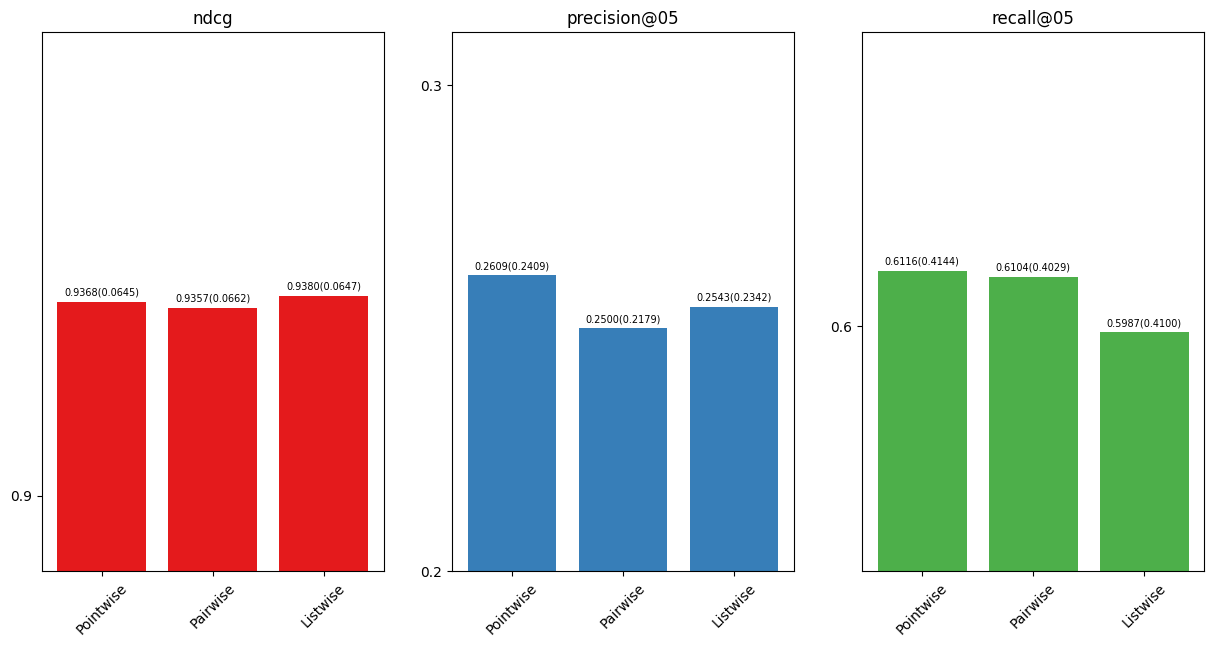

In [13]:
from ltr.utils import compare_methods

compare_methods(labels, results)

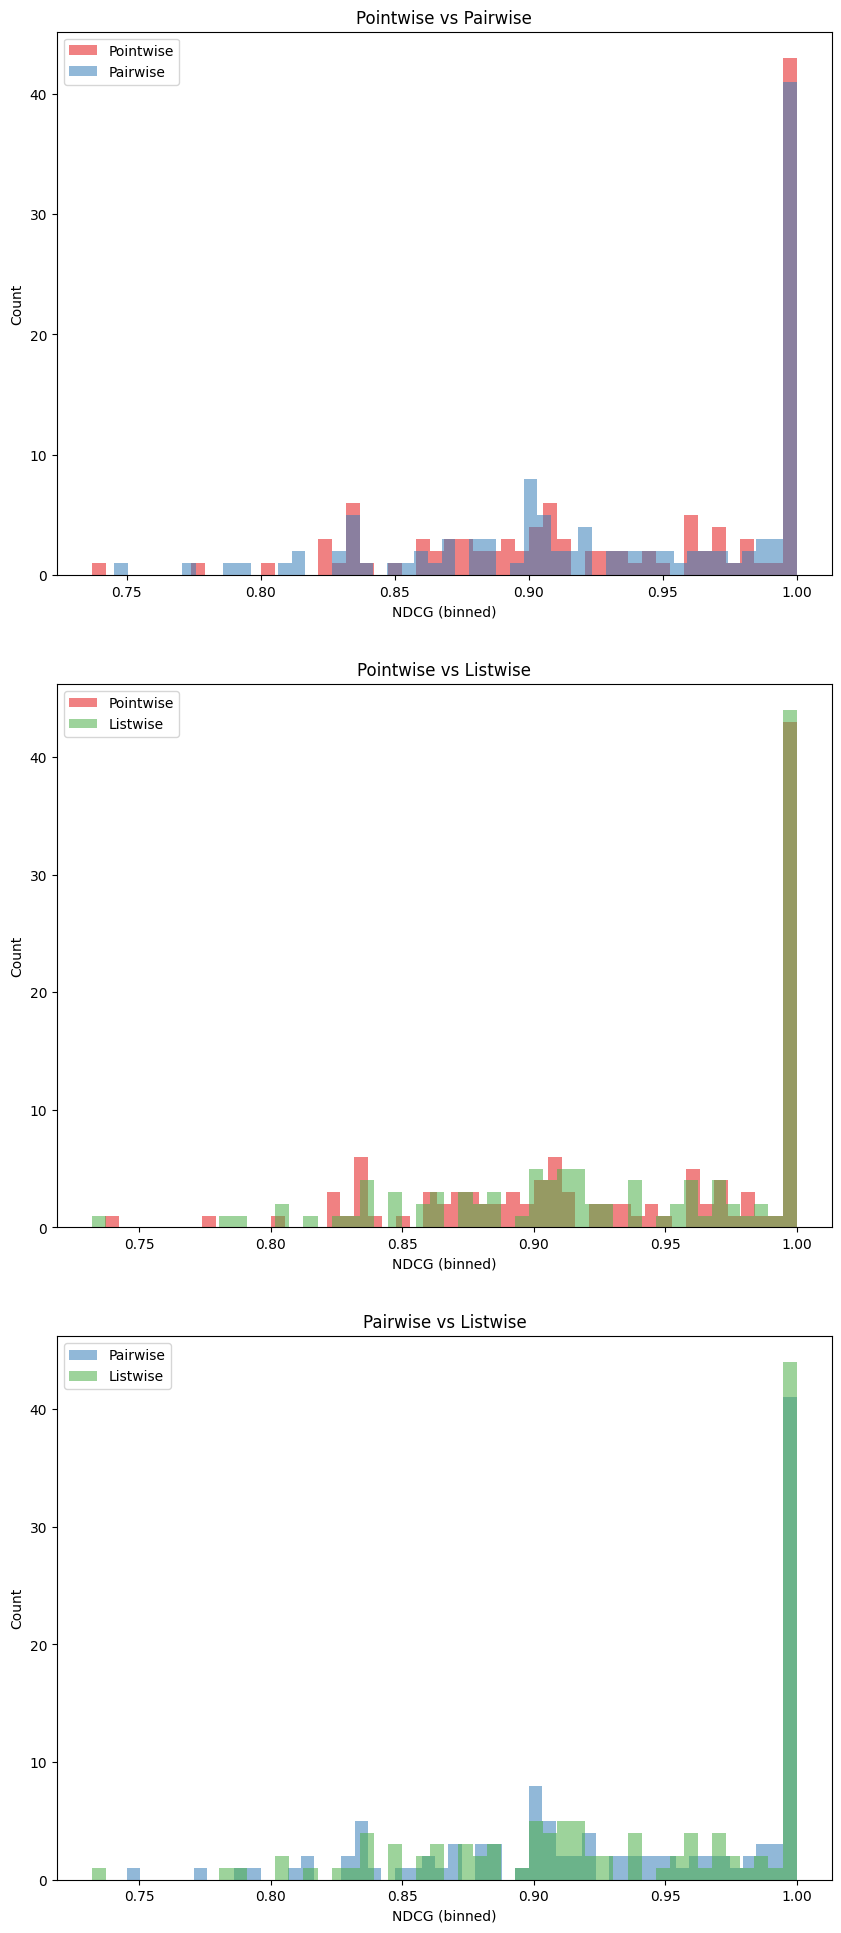

In [14]:
from ltr.utils import plot_distribution

plot_distribution(labels, q_results)

## Comparison before after NUTRITION

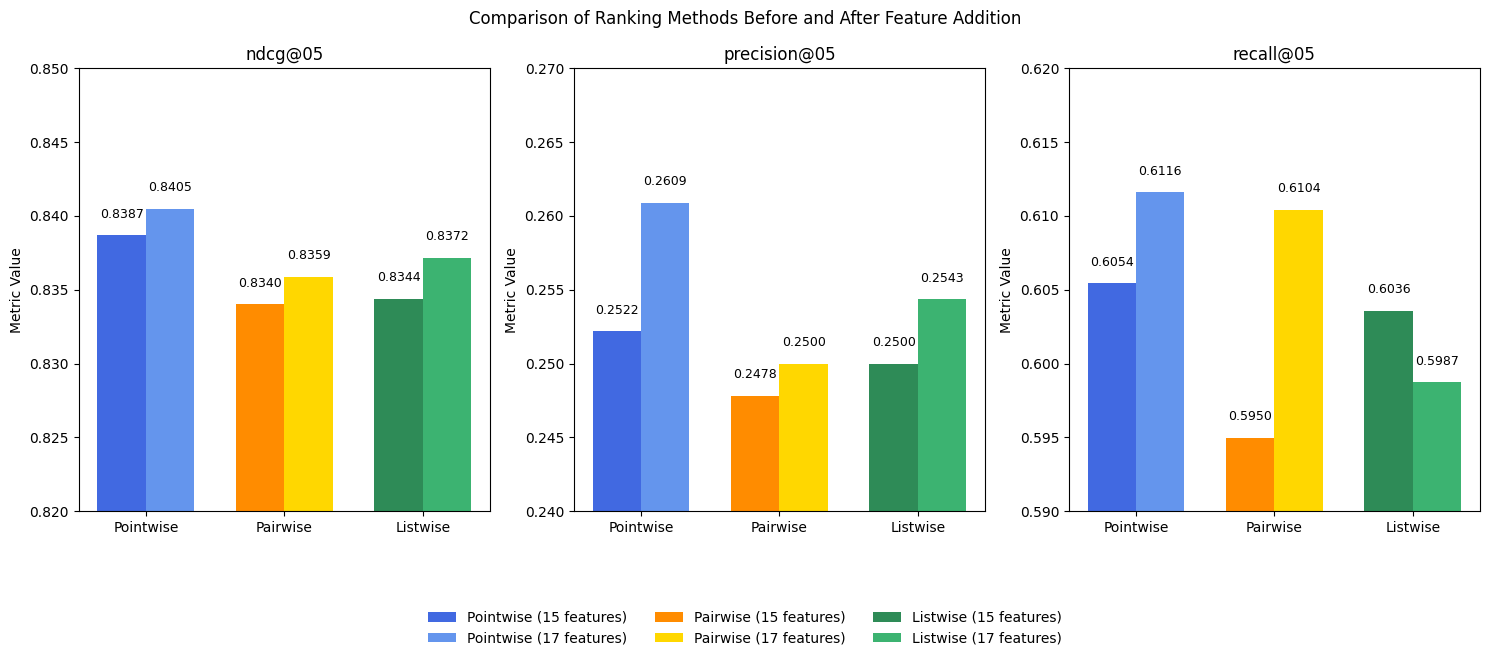

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

before_files = {
    "Pointwise": "./analysis_data/outputs_nutrition/pointwise_res.json",
    "Pairwise": "./analysis_data/outputs_nutrition/pairwise_spedup_res.json",
    "Listwise": "./analysis_data/outputs_nutrition/listwise_res.json",
}

after_files = {
    "Pointwise": "./analysis_data/outputs_nutrition_new/pointwise_res.json",
    "Pairwise": "./analysis_data/outputs_nutrition_new/pairwise_spedup_res.json",
    "Listwise": "./analysis_data/outputs_nutrition_new/listwise_res.json",
}

metrics_to_plot = ["ndcg@05", "precision@05", "recall@05"]
methods = ["Pointwise", "Pairwise", "Listwise"]

def load_metrics(file_paths):
    results = {}
    for method, file_path in file_paths.items():
        with open(file_path) as f:
            data = json.load(f)
            results[method] = {metric: data["test_metrics"].get(metric, [0, 0]) for metric in metrics_to_plot}
    return results

before_results = load_metrics(before_files)
after_results = load_metrics(after_files)

fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_plot), figsize=(15, 6))

method_colors = {
    "Pointwise": ("royalblue", "cornflowerblue"),
    "Pairwise": ("darkorange", "gold"),
    "Listwise": ("seagreen", "mediumseagreen"),
}

y_axis_limits = {
    "ndcg@05": (0.82, 0.85),  
    "precision@05": (0.24, 0.27), 
    "recall@05": (0.59, 0.62)  
}

x = np.arange(len(methods))  
width = 0.35  

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    before_values = [before_results[method][metric][0] for method in methods]
    after_values = [after_results[method][metric][0] for method in methods]

    rects = []
    for i, method in enumerate(methods):
        rect_before = ax.bar(x[i] - width/2, before_values[i], width, color=method_colors[method][0], label=f"{method} (15 features)" if idx == 0 else "")
        rect_after = ax.bar(x[i] + width/2, after_values[i], width, color=method_colors[method][1], label=f"{method} (17 features)" if idx == 0 else "")
        rects.extend(rect_before + rect_after)

    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.set_title(metric)
    ax.set_ylabel("Metric Value")
    ax.set_ylim(y_axis_limits[metric])
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.005))

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.001, f"{height:.4f}", 
                ha="center", va="bottom", fontsize=9)

fig.legend(loc="lower center", ncol=3, fontsize=10, frameon=False, bbox_to_anchor=(0.5, -0.1))

plt.suptitle("Comparison of Ranking Methods Before and After Feature Addition")
plt.tight_layout(rect=[0, 0.08, 1, 1]) 
plt.show()


## Per-Query Analysis

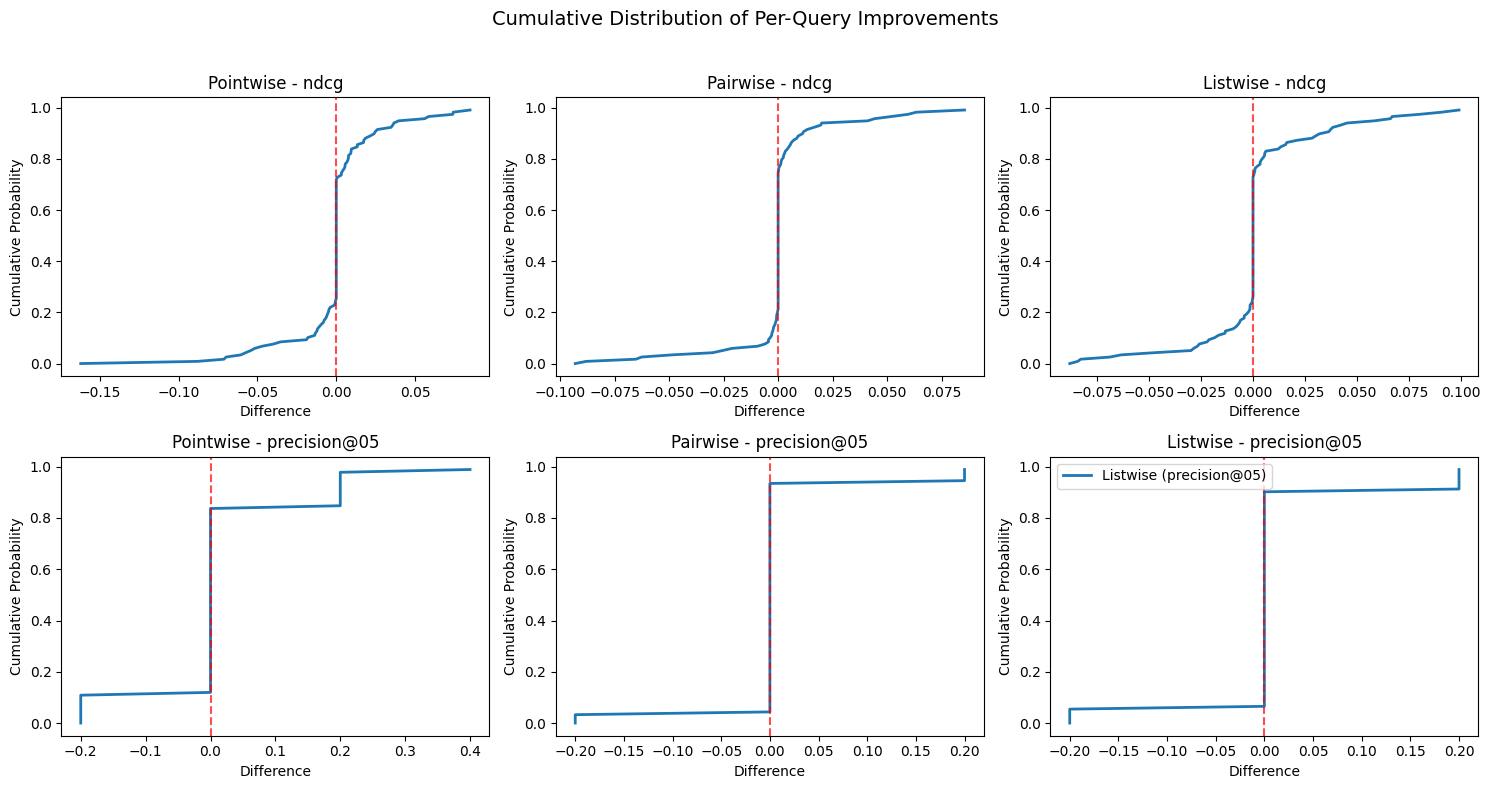

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd


before_files = {
    "Pointwise": "./analysis_data/outputs_nutrition/pointwise_res.json",
    "Pairwise": "./analysis_data/outputs_nutrition/pairwise_spedup_res.json",
    "Listwise": "./analysis_data/outputs_nutrition/listwise_res.json",
}

after_files = {
    "Pointwise": "./analysis_data/outputs_nutrition_new/pointwise_res.json",
    "Pairwise": "./analysis_data/outputs_nutrition_new/pairwise_spedup_res.json",
    "Listwise": "./analysis_data/outputs_nutrition_new/listwise_res.json",
}

metrics = ["ndcg", "precision@05"]

def load_per_query_metrics(file_path):
    """Loads per-query evaluation metrics from a JSON file."""
    with open(file_path) as f:
        data = json.load(f)
    return data.get("test_query_level_metrics", {})

fig, axes = plt.subplots(len(metrics), len(before_files), figsize=(15, 8))
fig.suptitle("Cumulative Distribution of Per-Query Improvements", fontsize=14)

for col, (method, before_file) in enumerate(before_files.items()):
    after_file = after_files[method]
    
    before_metrics = load_per_query_metrics(before_file)
    after_metrics = load_per_query_metrics(after_file)
    
    for row, metric in enumerate(metrics):
        before_values = np.array(before_metrics.get(metric, []))
        after_values = np.array(after_metrics.get(metric, []))

        if len(before_values) == 0 or len(after_values) == 0:
            continue
        
        diffs = after_values - before_values  
        sorted_diffs = np.sort(diffs)
        cdf = np.arange(len(diffs)) / len(diffs)

        ax = axes[row, col]
        ax.plot(sorted_diffs, cdf, label=f"{method} ({metric})", linewidth=2)

        ax.axvline(0, color='red', linestyle='dashed', alpha=0.7)

        ax.set_title(f"{method} - {metric}")
        ax.set_xlabel("Difference")
        ax.set_ylabel("Cumulative Probability")

        t_stat, p_value = stats.ttest_rel(before_values, after_values)

plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [2]:
queries_file = "./analysis_data/NUTRITION/queries.tsv"

before_files = {
    "Pointwise": "./analysis_data/outputs_nutrition/pointwise_res.json",
    "Pairwise": "./analysis_data/outputs_nutrition/pairwise_spedup_res.json",
    "Listwise": "./analysis_data/outputs_nutrition/listwise_res.json",
}

after_files = {
    "Pointwise": "./analysis_data/outputs_nutrition_new/pointwise_res.json",
    "Pairwise": "./analysis_data/outputs_nutrition_new/pairwise_spedup_res.json",
    "Listwise": "./analysis_data/outputs_nutrition_new/listwise_res.json",
}

queries_df = pd.read_csv(queries_file, sep="\t", header=None, names=["query_id", "query"])

queries_dict = {idx: query_id for idx, query_id in enumerate(queries_df["query_id"])}
query_text_dict = {query_id: text for query_id, text in zip(queries_df["query_id"], queries_df["query"])}

metrics = ["ndcg", "precision@05"]

def load_query_metrics(filepath):
    with open(filepath) as f:
        data = json.load(f)
    return data["test_query_level_metrics"]
for model in before_files.keys():
    print(f"\n### {model} Model ###\n")


    before_metrics = load_query_metrics(before_files[model])
    after_metrics = load_query_metrics(after_files[model])

    for metric in metrics:
        before_values = np.array(before_metrics[metric])
        after_values = np.array(after_metrics[metric])
        improvement = after_values - before_values

        top_queries = np.argsort(-improvement)[:5]  
        worst_queries = np.argsort(improvement)[:5] 

        print(f"\nTop 5 Queries with Highest {metric} Improvement:")
        for idx in top_queries:
            query_id = queries_dict.get(idx, f"[Unknown Query ID {idx}]")
            query_text = query_text_dict.get(query_id, "[Query text not found]")
            print(f"  {query_id}: {query_text}")

        print(f"\nWorst 5 Queries with {metric} Drop:")
        for idx in worst_queries:
            query_id = queries_dict.get(idx, f"[Unknown Query ID {idx}]")
            query_text = query_text_dict.get(query_id, "[Query text not found]")
            print(f"  {query_id}: {query_text}")



### Pointwise Model ###


Top 5 Queries with Highest ndcg Improvement:
  PLAIN-187: best dried fruit for cholesterol
  PLAIN-172: tarragon toxicity ?
  PLAIN-141: ginger & lemon balm for radiation exposure
  PLAIN-184: raisins vs. energy gels for athletic performance
  PLAIN-120: preloading with watercress before exercise

Worst 5 Queries with ndcg Drop:
  PLAIN-116: pistachios may help erectile dysfunction
  PLAIN-191: treating parkinson ’ s disease with diet
  PLAIN-168: why are eggs linked to cancer progression ?
  PLAIN-140: trans fat in animal fat
  PLAIN-200: is coconut oil bad for you ?

Top 5 Queries with Highest precision@05 Improvement:
  PLAIN-198: which pets improve children ’ s health ?
  PLAIN-202: head shrinking from grilling meat
  PLAIN-190: hibiscus tea : the best beverage ?
  PLAIN-145: fukushima radiation and seafood
  PLAIN-184: raisins vs. energy gels for athletic performance

Worst 5 Queries with precision@05 Drop:
  PLAIN-200: is coconut oil bad for you ?
  PLA